In [ ]:
# Importing Libraries



In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Dataset\Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
print(df['airline_sentiment'].value_counts())

print(df.isnull().sum())


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


- Data Preprocessing

In [8]:
import spacy

# Load English model
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Remove stopwords, punctuation, spaces, URLs, mentions, and convert to lemma in lowercase
        if (not token.is_stop 
            and not token.is_punct 
            and not token.like_url 
            and not token.like_email 
            and not token.text.startswith('@')  # remove mentions
            and not token.is_space):
            tokens.append(token.lemma_.lower())
    return " ".join(tokens)

# Apply preprocessing
df['spacy_processed_text'] = df['text'].apply(spacy_preprocess)

print(df[['text', 'spacy_processed_text']].head())


c:\Users\hp\anaconda3\envs\python_course\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                spacy_processed_text  
0                                                say  
1               plus add commercial experience tacky  
2                               today mean need trip  
3  aggressive blast obnoxious entertainment guest...  
4                                      big bad thing  


- Sentiment Encoding

In [9]:
# Encoding sentiment as numerical values
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_score'] = df['airline_sentiment'].map(sentiment_map)

print(df[['airline_sentiment', 'sentiment_score']].head())


  airline_sentiment  sentiment_score
0           neutral                0
1          positive                1
2           neutral                0
3          negative               -1
4          negative               -1


- Feature Extraction using TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=3000)

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['spacy_processed_text'])
y = df['sentiment_score']

print(f"Shape of TF-IDF matrix: {X.shape}")


Shape of TF-IDF matrix: (14640, 3000)


- Train/Test Split and Model Training

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7855191256830601

Classification Report:
               precision    recall  f1-score   support

          -1       0.82      0.93      0.87      1889
           0       0.62      0.47      0.54       580
           1       0.79      0.60      0.68       459

    accuracy                           0.79      2928
   macro avg       0.74      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



- Sentiment Distribution

C:\Users\hp\AppData\Local\Temp\ipykernel_14204\4112222952.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='Set2')


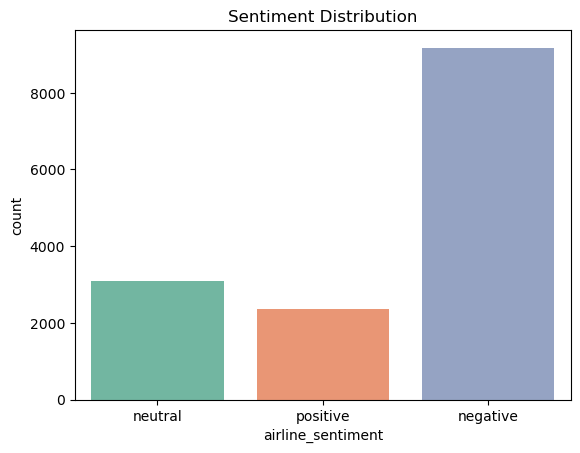

<Figure size 640x480 with 0 Axes>

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.show()
plt.savefig('images\Sentiment_Distribution.png', dpi=300, bbox_inches='tight')


- Word Clouds for Sentiment Classes

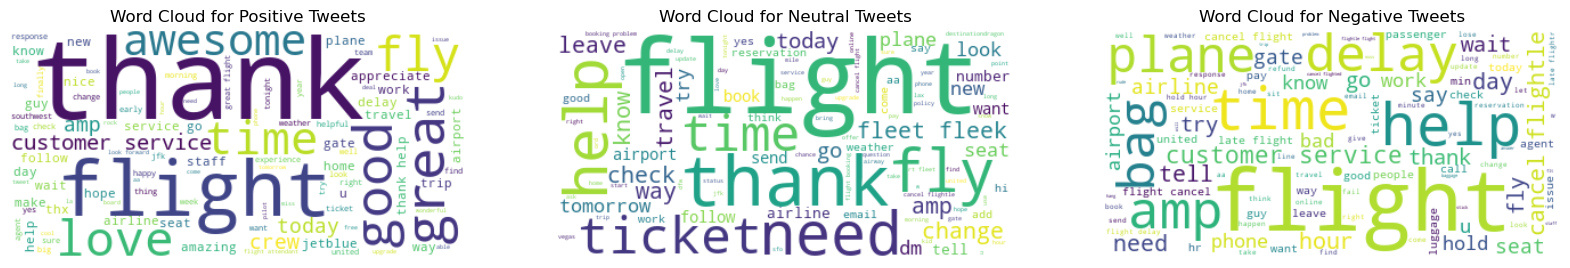

<Figure size 640x480 with 0 Axes>

In [16]:
from wordcloud import WordCloud

# Word clouds for positive, neutral, and negative tweets
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for ax, sentiment in zip(axes, ['positive', 'neutral', 'negative']):
    text = " ".join(df[df['airline_sentiment'] == sentiment]['spacy_processed_text'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for {sentiment.capitalize()} Tweets')
    ax.axis('off')

plt.show()
plt.savefig('images\Tweets_Word_Cloud.png', dpi=300, bbox_inches='tight')


- Sentiment Trend Over Time

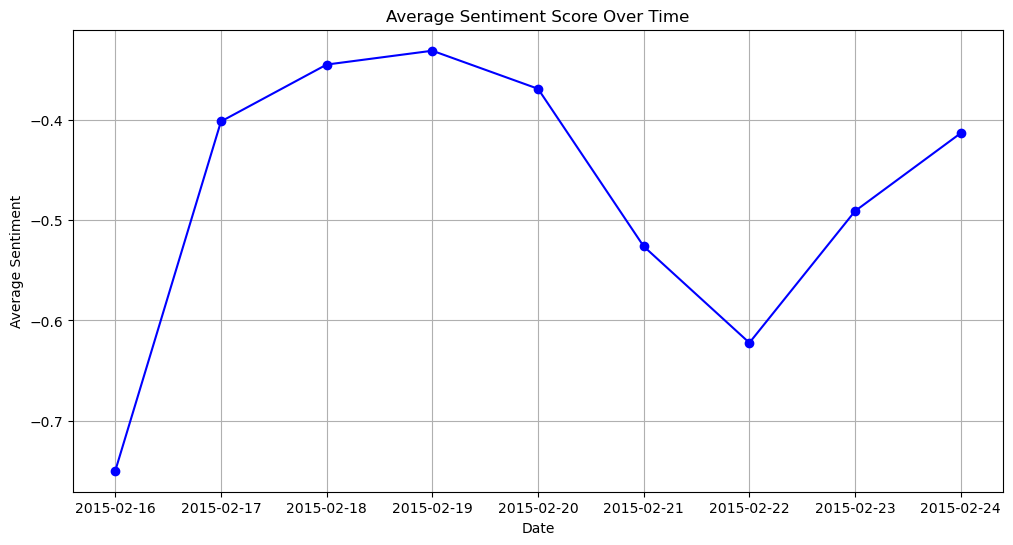

<Figure size 640x480 with 0 Axes>

In [17]:
# Convert tweet_created to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'], errors='coerce')

# Group by date and calculate average sentiment score
daily_sentiment = df.groupby(df['tweet_created'].dt.date)['sentiment_score'].mean()

plt.figure(figsize=(12, 6))
daily_sentiment.plot(marker='o', linestyle='-', color='blue')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()
plt.savefig('images\Average_Sentiment_Score_Over_Time.png', dpi=300, bbox_inches='tight')